<a href="https://colab.research.google.com/github/BI-DS/EBA-3530/blob/main/Lecture_4/bootstrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

# Bootstrapping

In the bootstrap algorithm we draw observations one at a time. After completing each sampling step, we place the observation back into the data sample. This procedure is called *sampling with replacement*. The (non-parametric) bootstrap algorithm looks like this:

---
Pseudo algorithm

---
<ol>
<li> Choose the size (n) for the bootstrapped dataset</li>
<li> while i <= B do</li>
<ul>
<li>Sample with replacement n observations, i.e. $\{x_i^b\}_{i=1}^n$</li>
<li> Use $\{x_i^b\}$ and calculate your estimate $\hat{\theta}_b^*$ </li>
</ul>
<li> Now you have $\{\hat{\theta}_b^*\}_{b=1}^B=\hat{\theta}_1^*,\hat{\theta}_2^*,\cdots,\hat{\theta}_B^*$. </li>
</ol>

---

  

## 1) Linear regression

Assume the true data generation process is

\begin{equation}
y=\beta x_1 +ϵ \tag{1}
\end{equation}

where $\beta=0.5$ and $\sigma^2=1$.  

1.1) Simulate 1000 $x_1$ observations using the folowing equation $x_1=u$ where $u\sim N(3,2^2)$

1.2) Using the variable $x_1$, simulate the dependet variable $y$ using equation 1).

1.3) Fit an OLS model to find an estimate $\beta_{OLS}$

In [10]:
#@title 1.1) simulate $x_1$
# The true regression parameters
b1 = 0.5
# The sample size for the original dataset
N = 1000

# Generate x_1
# this function takes standard deviation as input, not variance
x = np.random.normal(3,2,N)

In [11]:
#@title 1.2) simulate y
# Generate the random errors
e = np.random.normal(0,1,N)
# Generate y
y = b1*x + e

In [12]:
#@title 1.3) Fit OLS to estimate $\beta$
# fit a linear regression and obtain the parameter estimate
ols_model = sm.OLS(y,x).fit()
b1_ols = ols_model.params[0]

# theoretical 95% confidence interval (bse is the standard error for the
# coefficients)
asym_95 = [b1_ols - 1.96*ols_model.bse[0], b1_ols + 1.96*ols_model.bse[0]]
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.734
Method:                 Least Squares   F-statistic:                              2763.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):                   6.97e-290
Time:                        21:28:57   Log-Likelihood:                         -1468.0
No. Observations:                1000   AIC:                                      2938.
Df Residuals:                     999   BIC:                                      2943.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 2) Bootstrap the $\beta$ parameter

2.1) Generate B=10000 bootstrapped samples with the same number of observations as in the original data set from the previous exercise and estimate the unknown $\beta$ coefficient

2.2) Save each bootstrapped $\beta$ coefficient in a list called `b1_bootstrapped`

In [13]:
#@title 2.1) boostrap algorithm

# The number of bootstrap simulations
B = 10000

# list to save the bootstrapped b_1 values
b1_bootstrapped=[]
for b in range(B):
    # sampling (only an index) with replacement
    indx_boot = np.random.choice(x.shape[0], size=N)

    # use the index to sample (with replacement) x and y
    yb   = y[indx_boot]
    xb   = x[indx_boot]

    # expand the dimension to get a matrix of sixe N x 1
    # so we can use matrix maltiplication later on
    xb = xb[:,None]
    yb = yb[:,None]

    # get OSL estimate via matrix formula (X'X)^(-1)X'y
    b1_b = np.dot(np.linalg.inv(np.dot(xb.T,xb)),np.dot(xb.T,yb))[0][0]

    # append estimate
    b1_bootstrapped.append(b1_b)


## 3) Confidence intervals for $\beta$
The list `b1_bootstrapped` contains the bootstrapped data set $\{\hat{\theta}_b^*\}_{b=1}^B$.

Assuming that
\begin{equation}
\hat{\theta}_b^* \sim N(\beta_{OLS}, \hat{s.e.}^2)
\end{equation}

we can estimate 95% confidence intervals using
\begin{equation}
{\beta}_{OLS}  \pm 1.96*s.e.(\hat{\beta}^*),
\end{equation}
where
\begin{equation}
s.e.(\hat{\beta}) \approx \sqrt{\frac{1}{B-1} \sum_{b=1}^B (\hat{\beta}_b^*  - \beta_{OLS})^2}
\end{equation}

3.1) Estimate 95% confidence intervarls for the bootstrap set of coefficients $\{\hat{\theta}_b^*\}_{b=1}^B$.

In [14]:
#@title 3.1) confidence interval
se_b1 = np.sqrt(np.sum((b1_bootstrapped - b1_ols)**2)/(B-1))
bootstr_95 = [b1_ols - 1.96*se_b1, b1_ols + 1.96*se_b1]
print(bootstr_95)


[0.4780512231013049, 0.5143954540095563]


3.2) plot the density of the bootstrapped parameters $\{\hat{\theta}_b^*\}_{b=1}^B$, together with the parameter estimated in the OLS model and the 95% confidence interval.

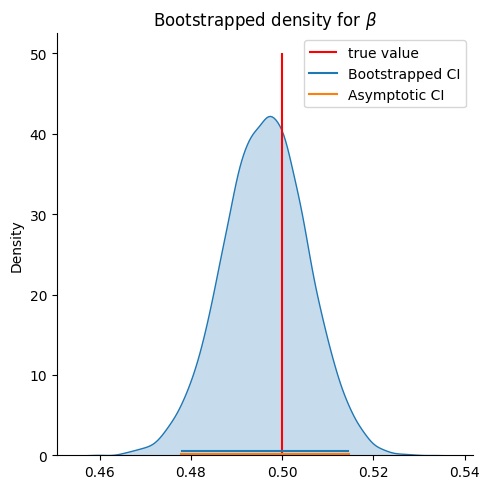

In [24]:
#@title 3.2) plot
sns.displot(b1_bootstrapped,kind='kde',fill=True)
plt.vlines(x=b1,ymin=0,ymax=50.,colors='r',label='true value')
plt.plot(bootstr_95,[0.5,0.5],label='Bootstrapped CI')
plt.plot(asym_95,[0.12,0.12],label='Asymptotic CI')
plt.legend()
plt.title(r'Bootstrapped density for $\beta$')
plt.tight_layout()
plt.savefig('bootstrap_1.pdf')
plt.show()

## Bonus topic
What is the uncertainty on the distribution for $\exp(\beta)$?
Getting the uncertainty from non-linear transformations on parameters can be impossible using the standard confidence
intervals. However, given simulated values from a Bootstrap, one can easily do the transformations and compute the correct confidence intervals/se. Hence, we can do this:

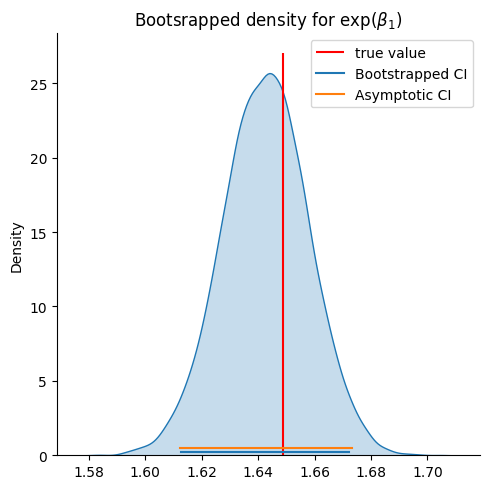

In [28]:
#@title bonus code
se_b1_exp = np.sqrt(np.sum((np.exp(b1_bootstrapped) - np.exp(b1_ols))**2/(B-1)))
b_95_b1_exp_int = [np.exp(b1_ols)- 1.96*se_b1_exp, np.exp(b1_ols) + 1.96*se_b1_exp]

sns.displot(np.exp(b1_bootstrapped),kind='kde',fill=True)
plt.vlines(x=np.exp(b1),ymin=0,ymax=27,colors='r',label='true value')
plt.plot(b_95_b1_exp_int,[0.2,0.2],label='Bootstrapped CI')
plt.plot(np.exp(asym_95),[0.5,0.5],label='Asymptotic CI')
plt.title(r'Bootsrapped density for $\exp(\beta_1)$')
plt.legend()
plt.tight_layout()
plt.savefig('bootstrap_2.pdf')
plt.show()